# 1. Load dataset
#### In this assignment, you are expected to build a model that finds clusters in the given face images dataset.
#### You will need to read the data from the archive file (faces.zip). It contains 400 images of 40 persons. Each image is 64x64. You can use zipfile for extracting the images, os for iterating the files and PIL for reading the images. Person labels are in the file names. Make sure you preserve the order of images and labels.

In [156]:
import zipfile
import os

cwd = os.getcwd()
destination = cwd + '/faces_exctracted'

with zipfile.ZipFile("faces.zip", 'r') as z:
    z.extractall(destination)

In [157]:
import pandas as pd
import numpy as np
from PIL import Image

directory = 'faces_exctracted'

list_of_photos = []
y = []

for filename in os.listdir(directory):
    path_to_photo = os.path.join(directory, filename)
    img = Image.open(path_to_photo)
    list_of_photos.append(np.array(img, dtype=np.uint16).reshape(-1))
    y.append(filename)

In [158]:
#plt.imshow(Image.fromarray(list_of_photos[0].reshape(64,64)), cmap='gray')

In [159]:
ds = pd.DataFrame(list_of_photos, columns = ["{}-{}".format(i, j)\
                  for i in range(1,65) for j in range(1,65)], dtype=np.uint16)
ds['filename'] = pd.Series(y)

In [160]:
print(ds)

     1-1  1-2  1-3  1-4  1-5  1-6  1-7  1-8  1-9  1-10  ...  64-56  64-57  \
0     75   89  101  107  128  147  159  164  167   166  ...    162    158   
1    110  114  124  135  144  155  165  170  172   170  ...     38     33   
2     77   97  119  128  142  159  165  166  170   169  ...     32     44   
3     48   47   47   47   46   46   59   98  117   125  ...    154    159   
4    121  132  141  151  157  167  168  173  175   177  ...     39     43   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...    ...    ...   
395  121  143  152  162  166  171  175  179  180   180  ...     16     20   
396  124  136  146  159  165  169  175  182  185   186  ...     23     24   
397   94  119  133  144  155  160  167  172  177   173  ...     19     20   
398   24   16   78  125  140  147  152  156  162   164  ...     80     83   
399   97  125  136  151  166  169  175  179  184   186  ...     21     39   

     64-58  64-59  64-60  64-61  64-62  64-63  64-64  filename  
0      160

In [161]:
#ds.describe()

# 2. Prepare dataset
#### Normalize the dataset (for this instance, you can normalize the whole dataset before split). Split the dataset into train (280 instances), validation (80 instances) and test sets (40 instances). When splitting, make sure there are same number of images per person in each set.

In [162]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = ds.iloc[:, :4096]
x_save2 = x
x = scaler.fit_transform(x)

In [163]:
x.shape

(400, 4096)

In [164]:
y = ds.iloc[:, -1:]

In [165]:
for i in range(y.size):
    y.iloc[i][0] = y.iloc[i][0].split('_')[0]

In [166]:
y.shape

(400, 1)

In [167]:
from sklearn.model_selection import StratifiedShuffleSplit
SEED = 42
strat_split = StratifiedShuffleSplit(\
            n_splits=1, test_size=40, random_state=SEED)

train_val_idx, test_idx = next(strat_split.split(x, y))
x_train_val = x[train_val_idx]
x_test = x[test_idx]
y_train_val = y.iloc[train_val_idx]
y_test = y.iloc[test_idx]

strat_split = StratifiedShuffleSplit(\
            n_splits=1, test_size=80, random_state=42)
train_idx, val_idx = next(\
                strat_split.split(x_train_val, y_train_val))

x_train = x_train_val[train_idx]
x_val = x_train_val[val_idx]
y_train = y_train_val.iloc[train_idx]
y_val = y_train_val.iloc[val_idx]

In [168]:
'''
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(x, train_size=280, shuffle=False, stratify=)
x_val, x_test = train_test_split(x_test, test_size = 40, shuffle=False)
'''

'\nfrom sklearn.model_selection import train_test_split\n\nx_train, x_test = train_test_split(x, train_size=280, shuffle=False, stratify=)\nx_val, x_test = train_test_split(x_test, test_size = 40, shuffle=False)\n'

In [169]:
x_val.shape

(80, 4096)

In [170]:
x_test.shape

(40, 4096)

# 3. PCA
#### Apply PCA on the data while preserving 99% of the variance.

In [171]:
x_train_save = x_train

In [172]:
from sklearn.decomposition import PCA
pca = PCA(n_components=262)
x_train = pca.fit_transform(x_train)
print()

In [173]:
print(pca.explained_variance_ratio_.cumsum()[-5:])

[0.9986089  0.99869493 0.9987806  0.99886308 0.99894448]


In [174]:
x.shape

(400, 4096)

In [175]:
x_train.shape

(280, 262)

In [176]:
x_val = pca.transform(x_val)
x_test = pca.transform(x_test)

# 4. Clustering
#### Apply k-means clustering with different k values (e.g., from 5 to 150, with step size of 5). You may want to save the models for later use.

In [177]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

SEED = 42
l1 = []
l2 = []

for n in range(5, 151, 5):
    kmeans = KMeans(n_clusters = n, random_state=SEED)
    kmeans.fit(x_train)
    l1.append(kmeans.inertia_)
    l2.append(silhouette_score(x_train, kmeans.labels_))

# 5. Analysis
#### Draw the elbow plot and silhouette scores plot. You can use silhouette_score from sklearn.

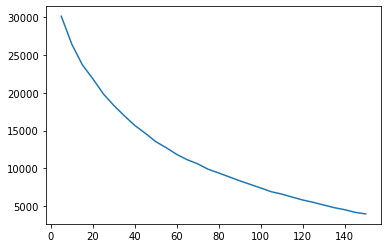

In [178]:
import matplotlib.pyplot as plt

x_elbow = [n for n in range(5, 151, 5)]
y_elbow = l1

plt.plot(x_elbow, y_elbow)

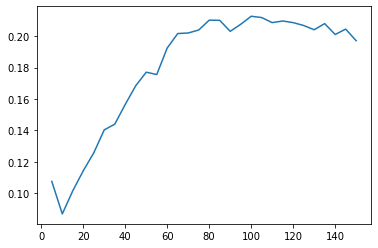

In [179]:
x_sil = [n for n in range(5, 151, 5)]
y_sil = l2

plt.plot(x_sil, y_sil)

#### Visualize the clusters (for 40 clusters and best k that you found from silhouette scores) to see whether there are similar faces in each cluster. You can use imshow from matplotlib to visualize images.

In [180]:
kmeans = KMeans(n_clusters = 100, random_state=SEED)
kmeans.fit(x_train)

KMeans(n_clusters=100, random_state=42)

In [181]:
x

array([[0.31034483, 0.3989071 , 0.41798942, ..., 0.10900474, 0.12060302,
        0.15706806],
       [0.51149425, 0.53551913, 0.53968254, ..., 0.10900474, 0.11055276,
        0.15183246],
       [0.32183908, 0.44262295, 0.51322751, ..., 0.09478673, 0.10552764,
        0.15183246],
       ...,
       [0.41954023, 0.56284153, 0.58730159, ..., 0.02843602, 0.02512563,
        0.05235602],
       [0.01724138, 0.        , 0.2962963 , ..., 0.507109  , 0.5678392 ,
        0.65968586],
       [0.43678161, 0.59562842, 0.6031746 , ..., 0.07109005, 0.12060302,
        0.15183246]])

In [182]:
def show_cluster(NUM):
    cluster = np.where(kmeans.labels_ == NUM)[0]
    fig = plt.figure(figsize=(12, 210))
    for n in cluster:
        index = y_train.iloc[n]
        true_index = index.name
        print(true_index)
        img = ds.iloc[312,:4096].values.reshape(64, 64).astype(np.uint16)
        fig.add_subplot(70, 4, np.where(cluster == n)[0][0] + 1)
        plt.imshow(img, cmap = 'gray')

301
305
306
304
302


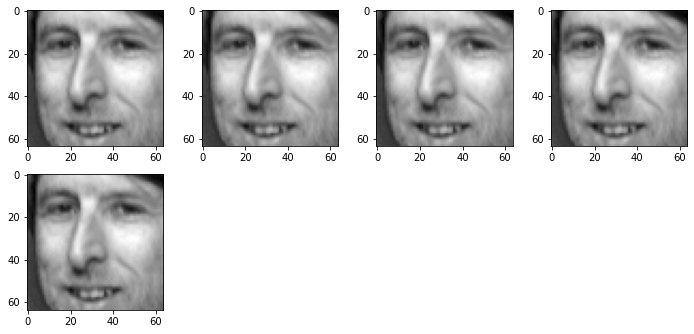

In [184]:
show_cluster(7)

In [185]:
kmeans = KMeans(n_clusters = 40, random_state=SEED)
kmeans.fit(x_train)

KMeans(n_clusters=40, random_state=42)

158
152
159


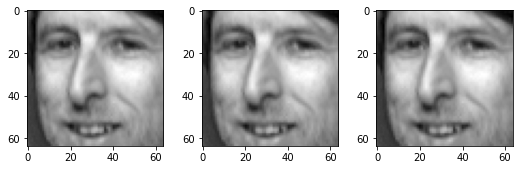

In [187]:
show_cluster(5)

In [188]:
'''
#Visualisation of all the faces (extra)
fig = plt.figure(figsize=(12, 210))
for n in range(0, 280):
    img = x_train[n,:].reshape(64, 64)
    fig.add_subplot(70, 4, n+1)
    plt.imshow(img, cmap = 'gray')
'''

"\n#Visualisation of all the faces (extra)\nfig = plt.figure(figsize=(12, 210))\nfor n in range(0, 280):\n    img = x_train[n,:].reshape(64, 64)\n    fig.add_subplot(70, 4, n+1)\n    plt.imshow(img, cmap = 'gray')\n"

#### Draw the silhouette diagram for 4 values of k: 20, 40, 60, 80. You may want to use the code below from Geron (with certain adjustments):
```python
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()
```

For n_clusters = 20 The average silhouette_score is : 0.1080519923975465
For n_clusters = 40 The average silhouette_score is : 0.1579530273928381
For n_clusters = 60 The average silhouette_score is : 0.19311720615068573
For n_clusters = 80 The average silhouette_score is : 0.20459349629070825


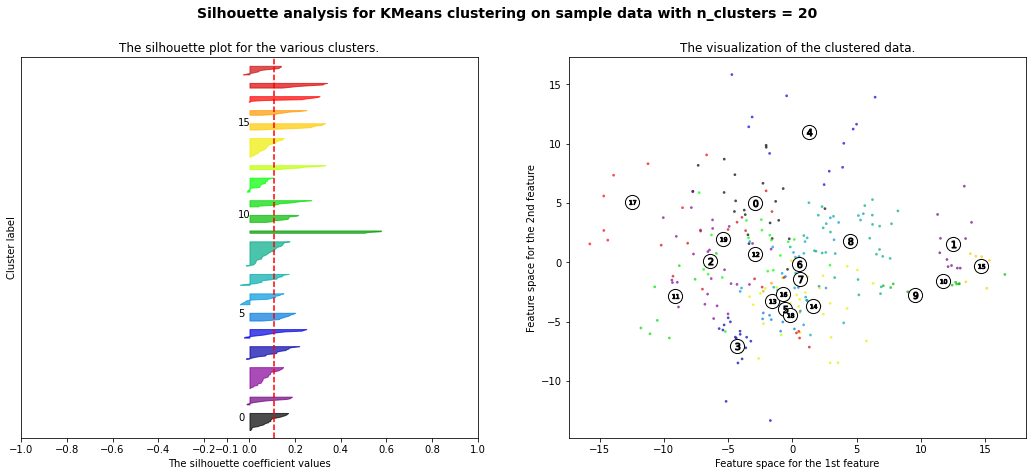

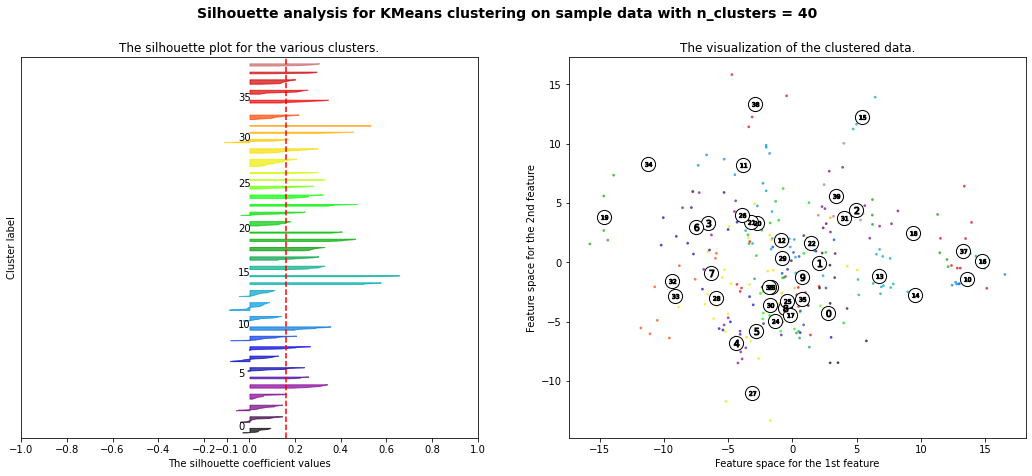

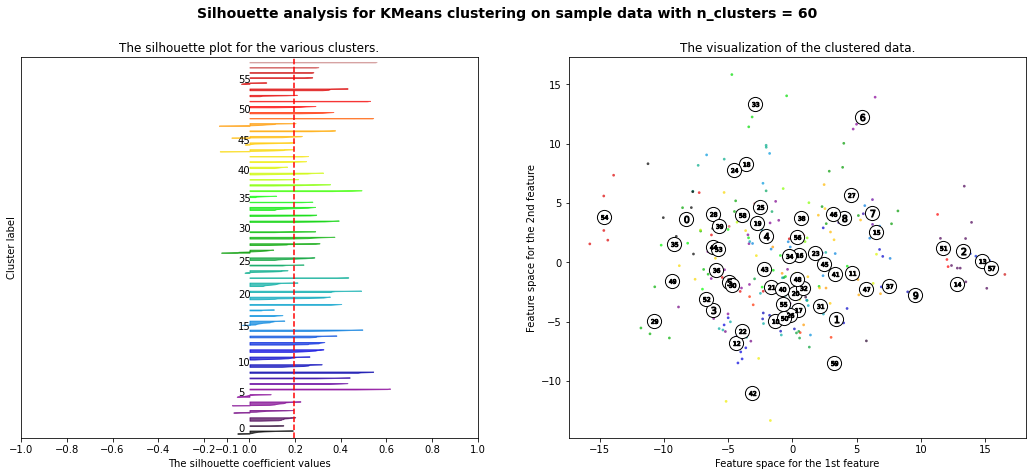

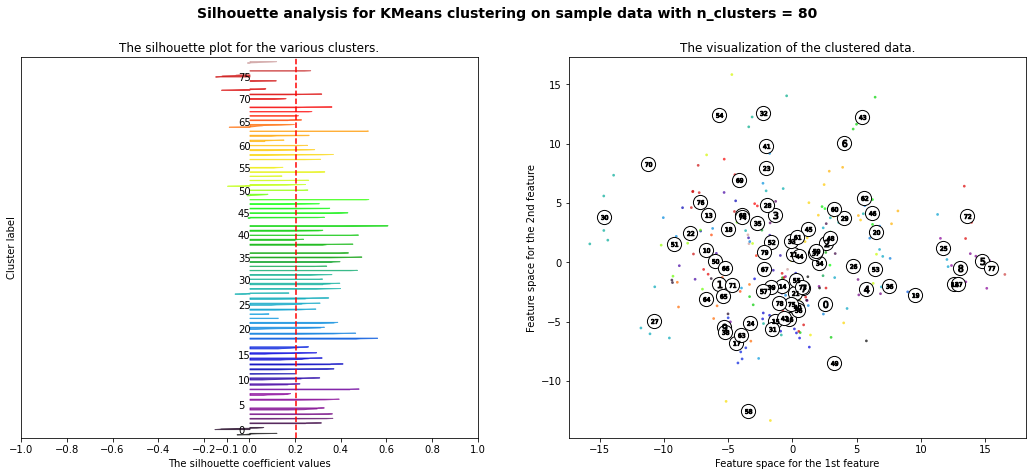

In [189]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

#Instead of Geron's code I used one from the official sklearn documentation
#I analyzed it and adjusted where necessary
X = x_train

range_n_clusters = [20, 40, 60, 80]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        if i%5 == 0:
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

# 6. Classification
#### Train a classifier on the train data to predict person on the image.

In [190]:
y_train = y_train.values.ravel()

In [191]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=SEED)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_val)
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.8875

#### Use best k-means model as a dimensionality reduction technique to reduce the dataset and train a classifier on the reduced data. Your data will have shape (280, number of clusters in the best model). You can use transform method of the k-means model.

In [192]:
kmeans = KMeans(n_clusters = 40, random_state=SEED)
kmeans.fit(x_train)

KMeans(n_clusters=40, random_state=42)

In [193]:
x_reduced = pd.DataFrame(kmeans.transform(x_train))

In [194]:
x_reduced.shape

(280, 40)

#### Create a pipeline to reduce the data (with k-means) with different numbers of clusters and train a classifier. Find out which value of k gives the best classification result.

In [195]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps= [('reducer', KMeans(n_clusters = 40, random_state=SEED)),
                        ('clf', RandomForestClassifier(random_state=SEED))]) 

from sklearn.model_selection import GridSearchCV
parameters = {'reducer__n_clusters':[95, 96, 97, 98, 99]}
search = GridSearchCV(pipe, parameters)

In [196]:
search.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('reducer',
                                        KMeans(n_clusters=40, random_state=42)),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'reducer__n_clusters': [95, 96, 97, 98, 99]})

In [197]:
search.best_params_

{'reducer__n_clusters': 97}

In [198]:
search.best_score_

0.7964285714285715

#### Add new features to original set of features and check again. Did you get better result than the case without new features?

In [199]:
x_train.shape

(280, 262)

In [200]:
kmeans = KMeans(n_clusters=99, random_state= SEED)
extra = kmeans.fit_transform(x_train, y_train)

In [201]:
x_train_extra = np.c_[x_train, extra]

In [202]:
x_train_extra.shape

(280, 361)

In [203]:
x_val_extra = kmeans.transform(x_val)

In [204]:
x_val_extra = np.c_[x_val, x_val_extra]

In [205]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=SEED)
clf.fit(x_train_extra, y_train)
y_pred = clf.predict(x_val_extra)

from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.8